In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer                    #type: ignore
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential                               #type: ignore
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,Dropout       #type: ignore
from tensorflow.keras.callbacks import EarlyStopping                         #type: ignore
import nltk
import re
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
BATCH_SIZE=128
EPOCHS=10


In [3]:
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

In [4]:
train=pd.read_csv(train_file_path,sep='\t',names=['class','text'])
test=pd.read_csv(test_file_path,sep='\t',names=['class','text'])

In [5]:
train

,class,text
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...
...,...,...
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...


In [6]:
test

,class,text
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?
...,...,...
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...


In [7]:
train_label=train['class'].astype('category').cat.codes
test_label=test['class'].astype('category').cat.codes


In [8]:
english_stopwords=set(stopwords.words('english'))
english_stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [9]:
lemmatizer=WordNetLemmatizer()

def lemmatization(text):
    test=re.sub(r'([^\s\w])+',' ',text)
    text=" ".join([lemmatizer.lemmatize(word) for word in test.split()
        if not word in stopwords.words('english')])
    text=text.lower()
    return text

In [10]:
x_train=train['text'].apply(lambda x:lemmatization(x))
x_train.head()

0    ahhhh woken bad dream u tho dont like u right ...
1                                        never nothing
2    u sound like manky scouse boy steve like trave...
3    mum say wan go go shun bian watch da glass exh...
4    never lei v lazy got wat dat day ü send da url...
Name: text, dtype: object

In [11]:
VOCAB_SIZE = 1000
MAX_LENGTH=500

In [12]:
token=Tokenizer(num_words=VOCAB_SIZE)
token.fit_on_texts(x_train)

In [13]:
seq=token.texts_to_sequences(x_train)
seq[:5]

[[309, 227, 1, 587, 42, 15, 1, 90, 359, 13, 103, 54, 228, 86],
 [195, 252],
 [1, 310, 15, 219, 15, 43, 311, 37, 386, 1, 6, 338, 422],
 [477, 58, 188, 8, 8, 243, 43],
 [195, 478, 167, 821, 18, 77, 212, 12, 28, 22, 43, 124, 70, 24]]

In [14]:
sequence_matrix=sequence.pad_sequences(seq,maxlen=MAX_LENGTH)
sequence_matrix

array([[  0,   0,   0, ...,  54, 228,  86],
       [  0,   0,   0, ...,   0, 195, 252],
       [  0,   0,   0, ...,   6, 338, 422],
       ...,
       [  0,   0,   0, ...,  71,  51, 100],
       [  0,   0,   0, ...,  35, 611, 954],
       [  0,   0,   0, ...,  40,  17, 108]])

In [15]:
model=Sequential([
    Input(shape=[MAX_LENGTH]),
    Embedding(VOCAB_SIZE, 50,input_length=MAX_LENGTH),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])



model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 87889 (343.32 KB)
Trainable params: 87889 (343.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
history=model.fit(sequence_matrix,train_label,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10


27/27 [==============================] - 13s 341ms/step - loss: 0.4846 - accuracy: 0.8594 - val_loss: 0.3619 - val_accuracy: 0.8612
Epoch 2/10
27/27 [==============================] - 9s 333ms/step - loss: 0.2600 - accuracy: 0.8884 - val_loss: 0.1441 - val_accuracy: 0.9665
Epoch 3/10
27/27 [==============================] - 8s 314ms/step - loss: 0.0881 - accuracy: 0.9779 - val_loss: 0.0709 - val_accuracy: 0.9797
Epoch 4/10
27/27 [==============================] - 9s 314ms/step - loss: 0.0395 - accuracy: 0.9889 - val_loss: 0.0491 - val_accuracy: 0.9880
Epoch 5/10
27/27 [==============================] - 8s 290ms/step - loss: 0.0311 - accuracy: 0.9919 - val_loss: 0.0445 - val_accuracy: 0.9904
Epoch 6/10
27/27 [==============================] - 8s 285ms/step - loss: 0.0231 - accuracy: 0.9946 - val_loss: 0.0450 - val_accuracy: 0.9916


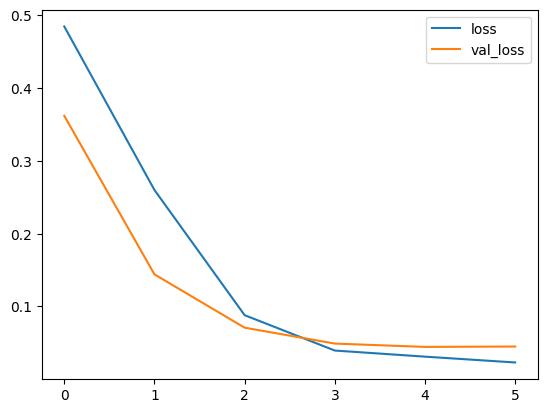

In [17]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

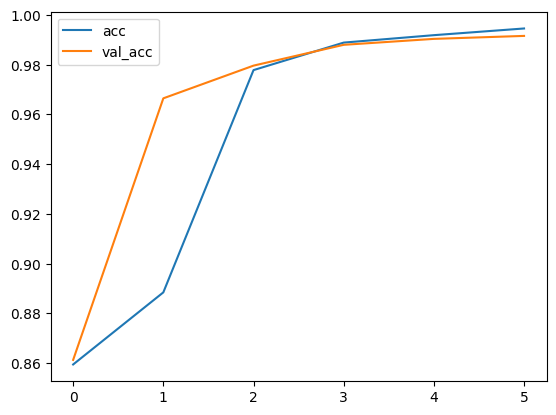

In [18]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [19]:
def preprocess(text):
    t=text.apply(lambda x:lemmatization(x))
    t=token.texts_to_sequences(t)
    return sequence.pad_sequences(t,maxlen=MAX_LENGTH)

In [20]:
results=model.evaluate(preprocess(test['text']), test_label)

44/44 [==============================] - 1s 33ms/step - loss: 0.0523 - accuracy: 0.9835


In [21]:
print(f'loss: {results[0]:.2%}, accuracy: {results[1]:.2%}')


loss: 5.23%, accuracy: 98.35%


In [40]:
def predict_text(text):
  p = model.predict(preprocess(pd.Series([text])))[0]
  print(p)

  return (p[0], ("ham" if p<0.5 else "spam"))

pred_text = "sale to stop texts call 98912460324" 

prediction = predict_text(pred_text)
print(prediction)

1/1 [==============================] - 0s 42ms/step
[0.53502774]
(0.53502774, 'spam')


In [23]:
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_text(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

1/1 [==============================] - 0s 32ms/step
[0.00076764]
1/1 [==============================] - 0s 34ms/step
[0.5591838]
1/1 [==============================] - 0s 33ms/step
[0.00056537]
1/1 [==============================] - 0s 33ms/step
[0.9914699]
1/1 [==============================] - 0s 34ms/step
[0.99508035]
1/1 [==============================] - 0s 34ms/step
[0.00158135]
1/1 [==============================] - 0s 34ms/step
[0.00042476]
You passed the challenge. Great job!


THE END!!